In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

import pickle

In [37]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [38]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


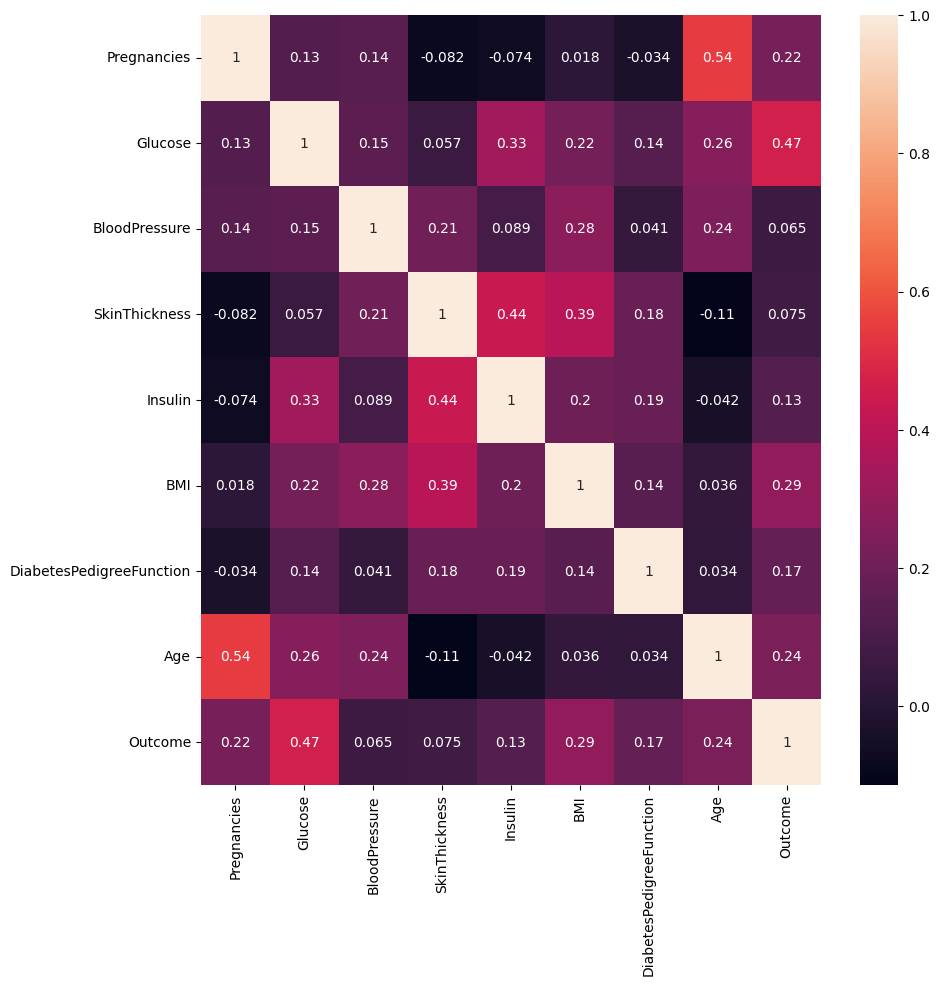

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [40]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [41]:
# Replacing zeroes with median
df['Insulin'] = df['Insulin'].replace(0, df['Insulin'].median())
df['Pregnancies'] = df['Pregnancies'].replace(0, df['Pregnancies'].median())
df['SkinThickness'] =  df['SkinThickness'].replace(0, df['SkinThickness'].median())
df['DiabetespedigreeFunction'] = df['DiabetesPedigreeFunction'].replace(0, df['DiabetesPedigreeFunction'].median())
df['Age'] = df['Age'].replace(0, df['Age'].median())

# Replacing zeroes with mean
df['Glucose'] = df['Glucose'].replace(0, df['Glucose'].mean())
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].mean())
df['BMI'] = df['BMI'].replace(0, df['BMI'].mean())

In [42]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

<Axes: >

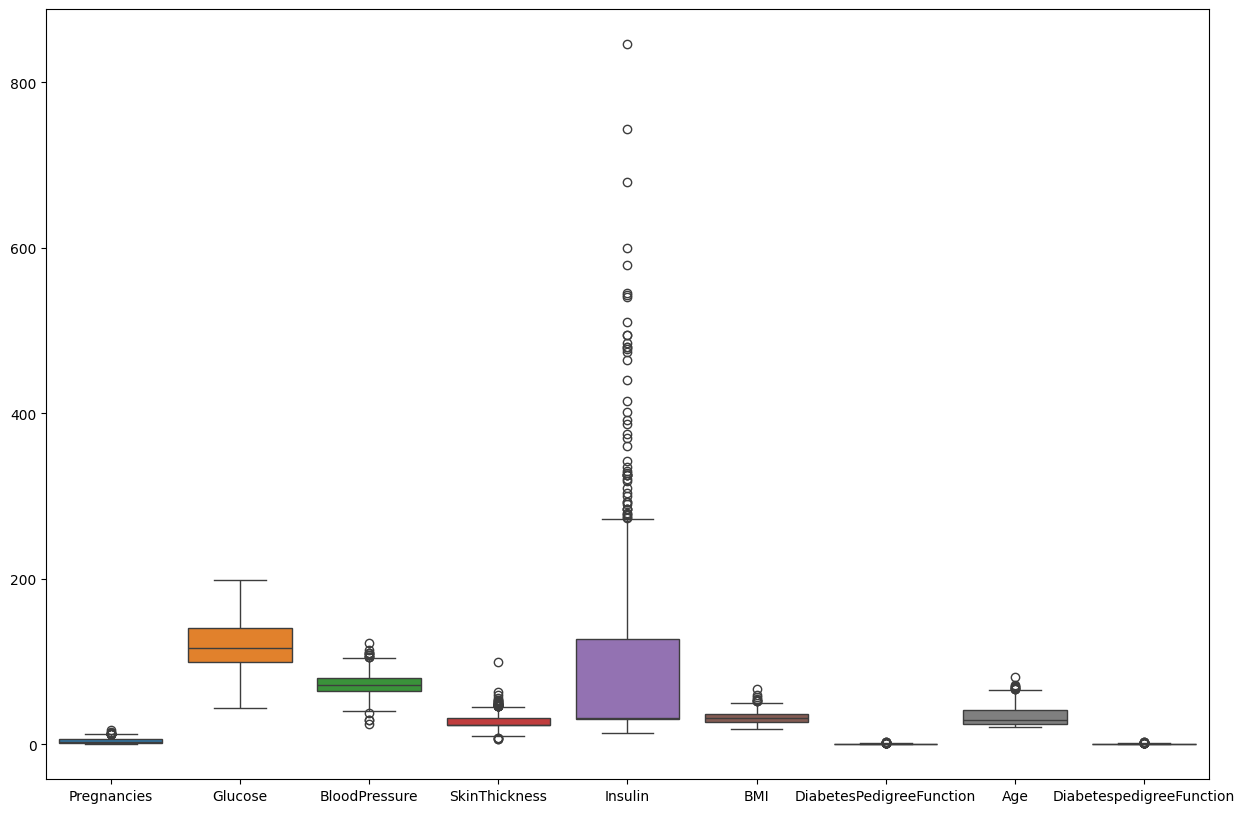

In [43]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(data = X, ax = ax)

In [44]:
for col in X.columns:
  q1 = X[col].quantile(0.25)
  q3 = X[col].quantile(0.75)
  iqr = q3 - q1
  upper_limit = q3 + 1.5 * iqr
  lower_limit = q1 - 1.5 * iqr
  mask = (X[col] >= lower_limit) & (X[col] <= upper_limit)

In [45]:
X_outlier_detection = X[mask]
y_outlier_detection = y[mask]

X_outlier_detection.shape

(739, 9)

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_outlier_detection)
X_scaled = pd.DataFrame(X_scaled, columns = X_outlier_detection.columns)

In [47]:
X_scaled.reset_index(drop = True, inplace = True)
y_outlier_detection.reset_index(drop = True, inplace = True)

In [48]:
q = X_scaled['Insulin'].quantile(.95)
mask = X_scaled['Insulin'] < q
dataNew = X_scaled[mask]
y_outlier_detection = y_outlier_detection[mask]

<Axes: >

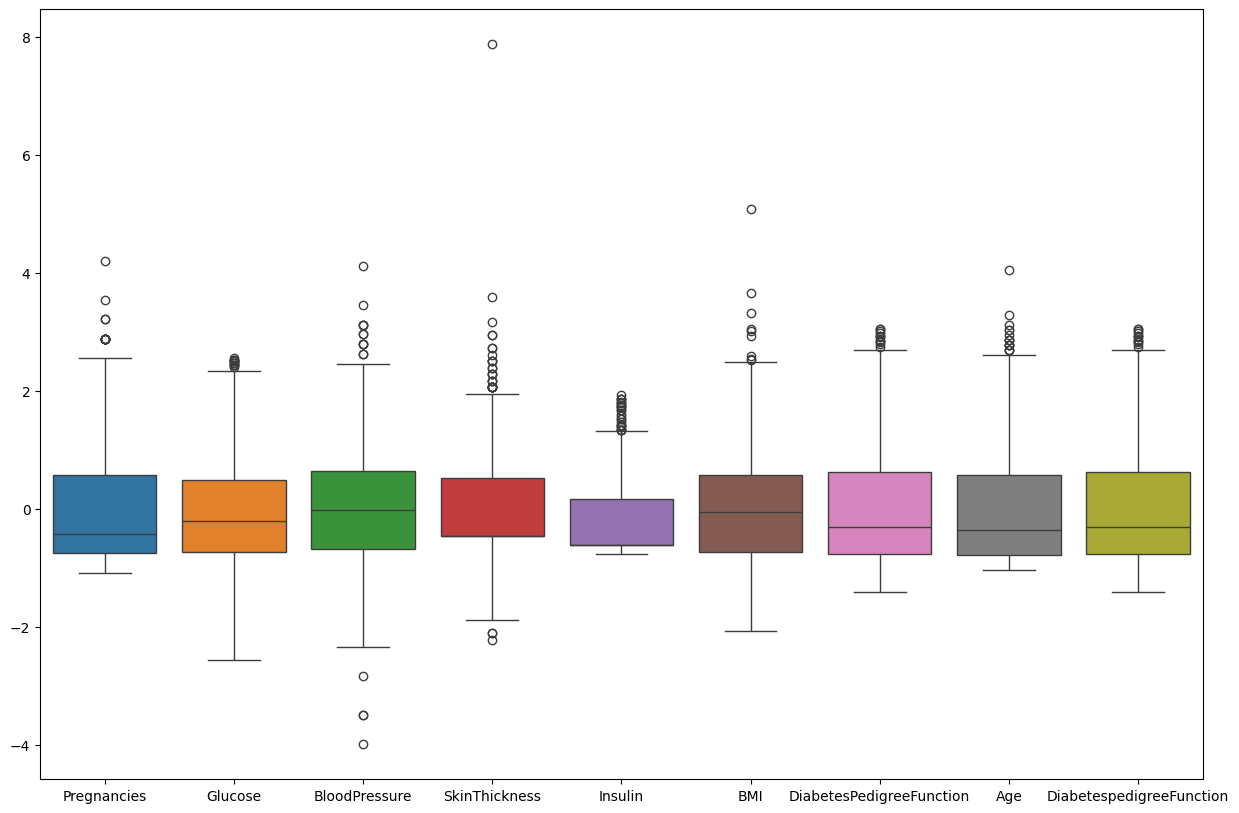

In [49]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(data = dataNew, ax=ax)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(dataNew, y_outlier_detection, test_size=0.2, random_state=42)

In [51]:
y_train.value_counts()

,count
Outcome,
0,375
1,186


In [52]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(y_train_smote.value_counts())

Outcome
0    375
1    375
Name: count, dtype: int64


# Logistic Regression

In [53]:
model = LogisticRegression()

model.fit(X_train_smote, y_train_smote)

LogisticRegression()

In [54]:
y_pred = model.predict(X_test)

In [55]:
print(confusion_matrix(y_test, y_pred))
print('-'*35)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

[[80 17]
 [13 31]]
-----------------------------------
Accuracy Score:  0.7872340425531915


In [56]:
print(classification_report(y_test, y_pred))

# 0: Non-Diabetic
# 1: Diabetic

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        97
           1       0.65      0.70      0.67        44

    accuracy                           0.79       141
   macro avg       0.75      0.76      0.76       141
weighted avg       0.79      0.79      0.79       141



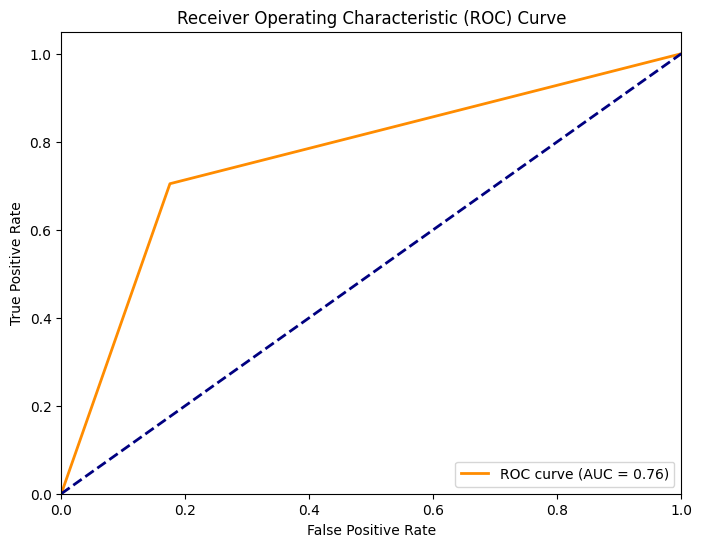

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [57]:
pickle.dump(model, open('model.pkl', 'wb'))